# Importing Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library Import

In [3]:
import pandas as pd
import numpy as np
import itertools # about itertools - https://www.youtube.com/watch?v=p8FUoSIyIVY 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import pacf

# Reading Data

## Reading train and test data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Data/train.csv")
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d') # formatting the date

In [5]:
df_test = pd.read_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Data/test.csv")
df_test["date"] = pd.to_datetime(df_test['date'], format='%Y-%m-%d') # formatting the date

In [6]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [8]:
df_final = pd.DataFrame(columns=['id','date','store_nbr','family','onpromotion','pred'])

## Reading store data

In [9]:
df_stores = pd.read_csv('/content/drive/MyDrive/ML Project /Time Series Analysis/Data/stores.csv')

In [10]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


# Creating Combination of store number, cluster & product family

In [11]:
#Fetching list of unique products and store numbers
family_list = df['family'].unique().tolist()
store_list = df['store_nbr'].unique().tolist()

In [12]:
comb_store_family = list(itertools.product(store_list, family_list))
len(comb_store_family)

1782

The number of unique combination of store number and product family is 1782

# Merging of store numbers with their respective cluster

In [13]:
df_merge = pd.merge(df, df_stores[['store_nbr','cluster']], how='left', on='store_nbr')

In [14]:
df_merge2 = pd.merge(df, df_stores[['store_nbr','city','state','type','cluster']], how='left', on='store_nbr')
df_merge2.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [15]:
df_merge2.shape

(3000888, 10)

In [21]:
df_merge.head()

,id,date,store_nbr,family,sales,onpromotion,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,13
1,1,2013-01-01,1,BABY CARE,0.0,0,13
2,2,2013-01-01,1,BEAUTY,0.0,0,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,13
4,4,2013-01-01,1,BOOKS,0.0,0,13


# Checking lags using PACF

In [22]:
family_list

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [23]:
cluster_mapping = df_merge[['store_nbr',"cluster","family"]].groupby(['store_nbr',"cluster","family"]).count().reset_index()

In [24]:
cluster_mapping.head()

,store_nbr,cluster,family
0,1,13,AUTOMOTIVE
1,1,13,BABY CARE
2,1,13,BEAUTY
3,1,13,BEVERAGES
4,1,13,BOOKS


# Lags deciding

Provide different store number, product family and cluster number to check pacf lag value per cluster

P-value:  0.0002845102919342618


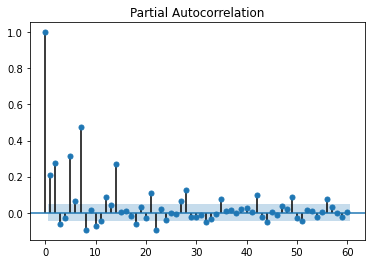

In [27]:
#providing custom inputs
list_df = cluster_mapping.values.tolist()
df_temp = df_merge[(df_merge['store_nbr']==51)&(df_merge['family']=="SEAFOOD")&(df_merge['cluster']==17)]
df_stationarityTest = adfuller(df_temp['sales'].values, autolag='AIC')
print("P-value: ", df_stationarityTest[1])
pacf = plot_pacf(df_temp['sales'].values, lags=60) #change "lags" according to convienience

In [ ]:
#from statsmodels.tsa.stattools import kpss
#kpss_scores = kpss(df_temp['sales'].values,regression='c', nlags=1, store=False)
#kpss_scores

In [28]:
#fetching every row in list
list_df = cluster_mapping.values.tolist()

In [29]:
#average lags per cluster
cluster_lag_map = {1:14,2:18,3:8,4:13,5:14,6:7,7:10,8:10,9:15,10:9,11:7,12:14,13:21,14:8,15:9,16:8,17:7}

# Modeling AR

In [ ]:
list_df #Unique combinations of store number, cluster and product family respectively.

## Running iterations for creating model from above combinations.

In [ ]:
for i in list_df:
  print("NEW ITERATION")
  print(i)
  df_temp = df_merge[(df_merge['store_nbr']==i[0])&(df_merge['family']==i[2])].reset_index(drop = True)
  df_temp["sales"] = np.log(df_temp["sales"]) #logarithmic normalization
  df_temp = df_temp.fillna(0) #filling null values
  df_temp = df_temp.replace([np.inf, -np.inf], 0) #filling values when log(0) takes place which cannot be computed
  df_test_temp =  df_test[(df_test['store_nbr']==i[0])&(df_test['family']==i[2])].reset_index(drop = True)
  if len(df_test_temp)>0:
    ar_model = AutoReg(df_temp["sales"], lags=cluster_lag_map[i[1]]).fit() #fitting the model
    df_test_temp["sales"] = np.exp(ar_model.predict(start=len(df_temp), end=(len(df_temp)+len(df_test_temp)-1), dynamic=False).reset_index(drop=True).values)
    df_final = pd.concat([df_final, df_test_temp])

In [ ]:
df_final.head()

,id,date,store_nbr,family,onpromotion,pred,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,3.369425
1,3002670,2017-08-17,1,AUTOMOTIVE,0,NaN,3.653849
2,3004452,2017-08-18,1,AUTOMOTIVE,0,NaN,3.821092
3,3006234,2017-08-19,1,AUTOMOTIVE,0,NaN,4.059933
4,3008016,2017-08-20,1,AUTOMOTIVE,0,NaN,2.811158


## Joining test set with predict to submission file based on id column

In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Data/sample_submission.csv")
# df_sample["sales"] = df_final["pred"].values
df_sample_merge = pd.merge(df_sample["id"], df_final[['id','sales']], how='left', on='id')
df_sample_merge.head()

,id,sales
0,3000888,3.369425
1,3000889,1.000000
2,3000890,2.844940
3,3000891,1924.088562
4,3000892,1.005446


## Saving the submission file to a drive

In [ ]:
df_sample_merge.to_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Submission files/AR_model_sub.csv",index=False)